In [6]:
# To help you get started...
from IPython.display import display
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from scipy.stats import scoreatpercentile
import math
from sklearn.preprocessing import minmax_scale
%matplotlib inline 

# Reading Multiple files into a list

In [7]:
filenames=[r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_0.csv',
           r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_1.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_2.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_3.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_4.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_5.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_6.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_7.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_8.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_9.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_10.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_11.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_12.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_13.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_14.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_15.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_16.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_17.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_18.csv',
r'C:\Users\srika\OneDrive\Desktop\Spring20\Tagup\exampleco_data-20200306T165930Z-001\exampleco_data\machine_19.csv']

In [8]:
df = []
for f in filenames:
    df.append(pd.read_csv(f,index_col=0))

# Necessary modifications for all the data for preprocessing

In [9]:
 for i in range(0,20):
    df[i]['Date_created']=df[i].index
    df[i]=df[i].reset_index(drop=True)
    df[i].rename(columns={'0':'sensor1',
                              '1':'sensor2',
                              '2':'sensor3','3':'sensor4'},inplace=True)
    cols = list(df[i].columns)
    cols = [cols[-1]] + cols[:-1]
    df[i] = df[i][cols]
    df[i]=df[i][abs(df[i].sensor1-df[i].sensor1.mean()) <= (3*df[i].sensor1.std())]
    df[i]=df[i][abs(df[i].sensor2-df[i].sensor2.mean()) <= (3*df[i].sensor2.std())]
    df[i]=df[i][abs(df[i].sensor3-df[i].sensor3.mean()) <= (3*df[i].sensor3.std())]
    df[i]=df[i][abs(df[i].sensor4-df[i].sensor4.mean()) <= (3*df[i].sensor4.std())]
    df[i]=df[i].reset_index(drop=True)
    df[i]['Date_created'] = pd.to_datetime(df[i]['Date_created'], errors='coerce')
    df[i]['day_of_week'] = df[i]['Date_created'].dt.dayofweek
    df[i]['month'] = pd.DatetimeIndex(df[i]['Date_created']).month
    df[i]['hour'] = pd.DatetimeIndex(df[i]['Date_created']).hour
    df[i][['sensor1','sensor2','sensor3','sensor4']] = minmax_scale(df[i][['sensor1','sensor2','sensor3','sensor4']])
    df[i]['sensor1']=df[i]['sensor1'].rolling(window=30).var()
    df[i]['sensor2']=df[i]['sensor2'].rolling(window=30).var()
    df[i]['sensor3']=df[i]['sensor3'].rolling(window=30).var()
    df[i]['sensor4']=df[i]['sensor4'].rolling(window=30).var()
    df[i]=df[i][30:]
    df[i]=df[i].reset_index(drop=True)
    df[i]=df[i].round({"sensor1":7, "sensor2":7, "sensor3":7, "sensor4":7})
    df[i] = df[i][(df[i][['sensor1','sensor2','sensor3','sensor4']] != 0).all(axis=1)]
    df[i]['mean_value']=df[i].apply(lambda row:((row.sensor1)**2 + (row.sensor2)**2 + (row.sensor3)**2 + (row.sensor4)**2)/4,axis=1)
    df[i]['Root_Mean_Square']=df[i].apply(lambda row:math.sqrt(row.mean_value),axis=1)
    tukey_hinge=df[i]['Root_Mean_Square'].quantile(0.75)
    df[i]['labels']=df[i].apply(lambda row:1 if row.Root_Mean_Square>tukey_hinge else 0,axis=1)
    df[i]=df[i].drop('mean_value',axis=1)

# Concatenating all the data

In [10]:
df_train=pd.concat([df[1],df[2],df[3],df[4],df[5],df[6],df[7],df[8],df[9],df[10],df[11],df[12],df[13],df[14],df[15],df[16],df[17],df[18],df[19]])

# Analysing the "sensors" data

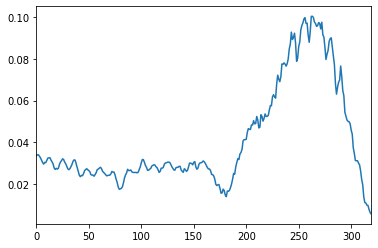

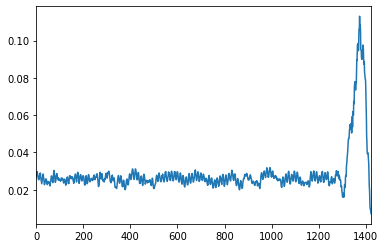

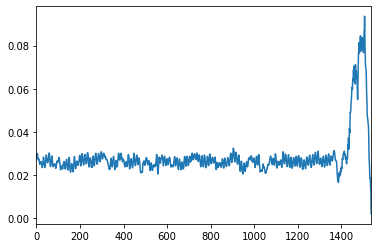

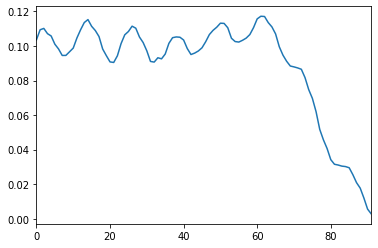

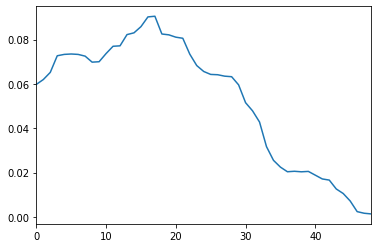

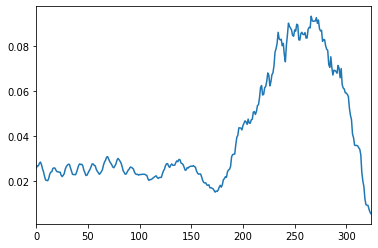

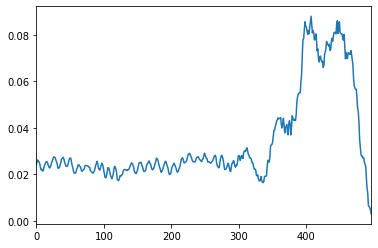

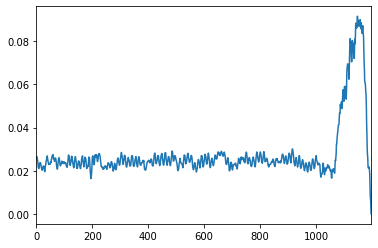

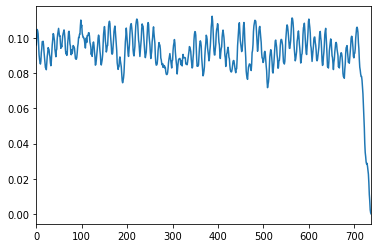

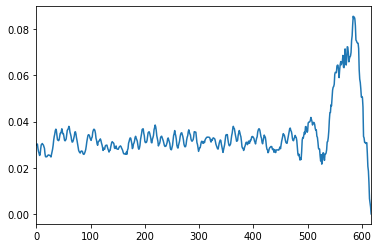

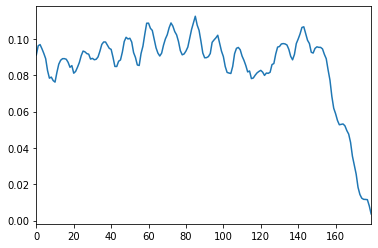

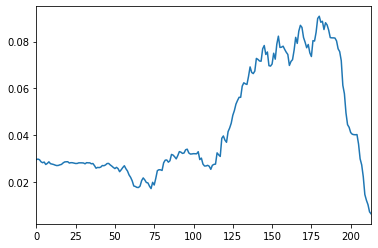

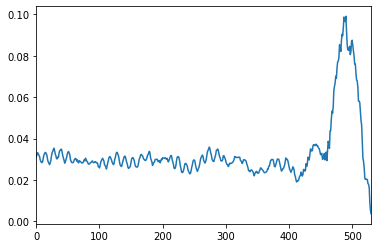

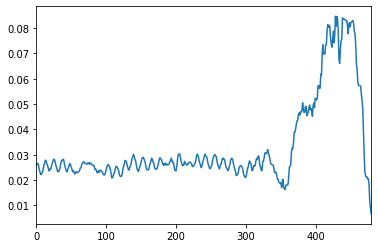

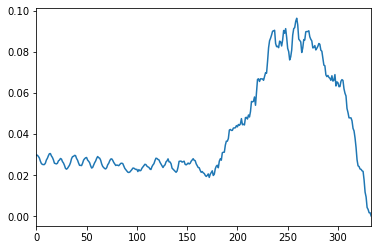

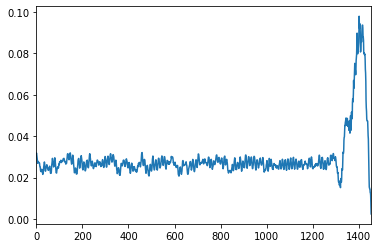

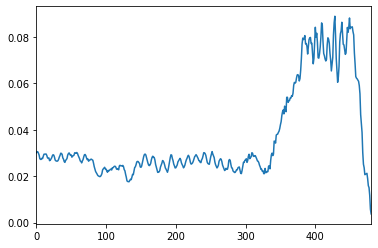

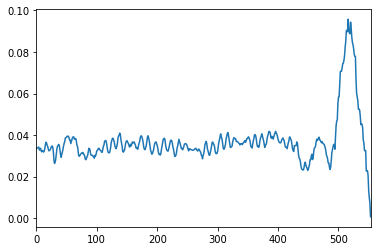

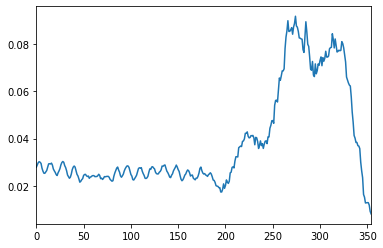

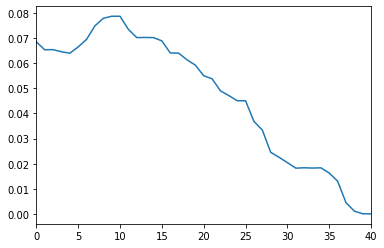

In [11]:
for i in range(0,20):
    plt.figure()
    df[i]['sensor1'].plot()
    plt.show()

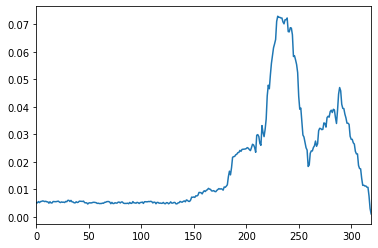

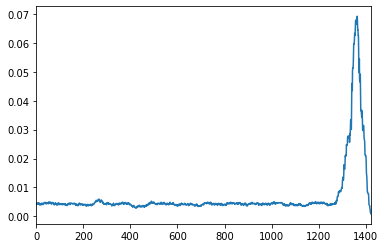

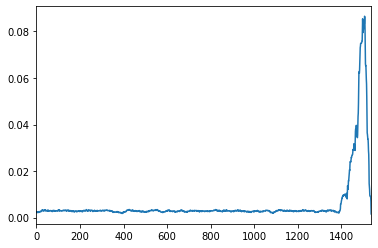

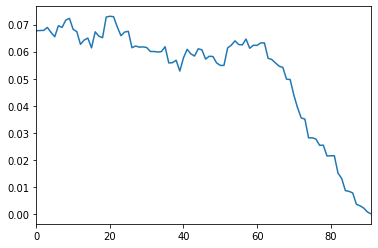

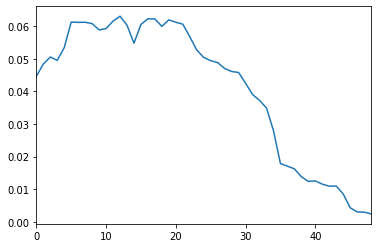

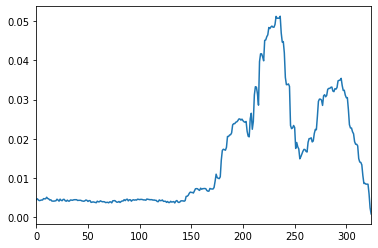

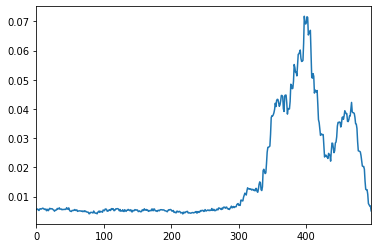

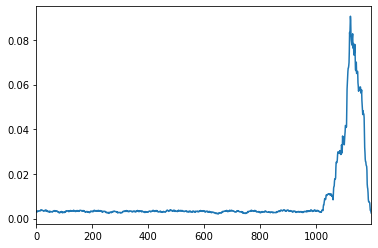

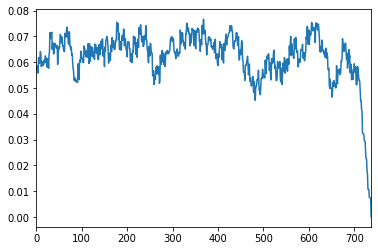

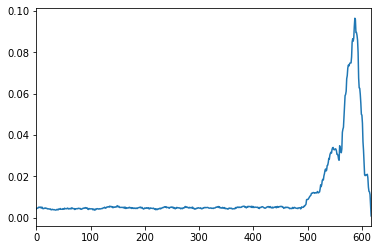

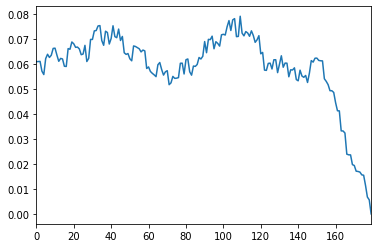

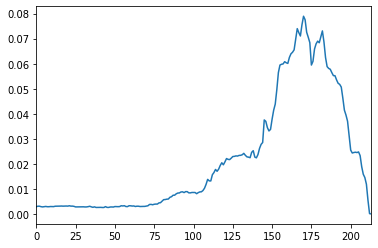

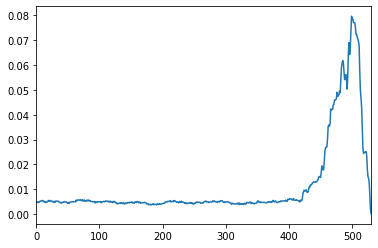

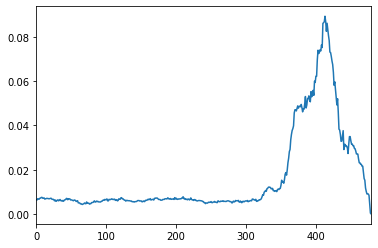

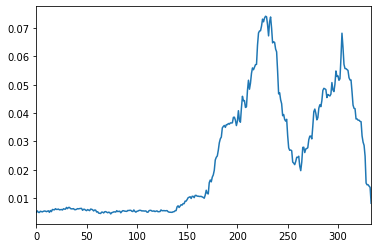

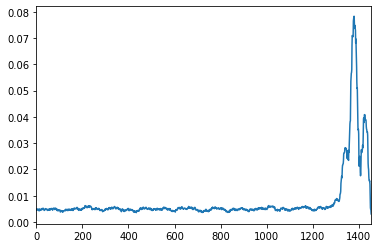

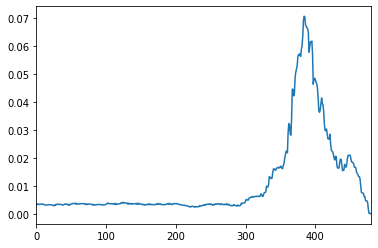

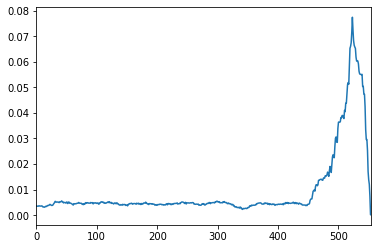

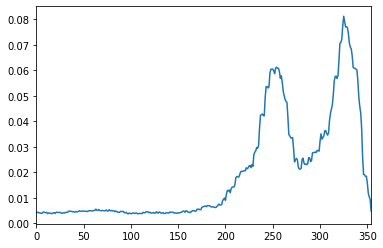

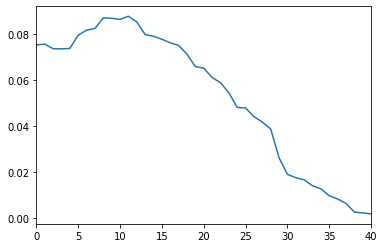

In [12]:
for i in range(0,20):
    plt.figure()
    df[i]['sensor2'].plot()
    plt.show()

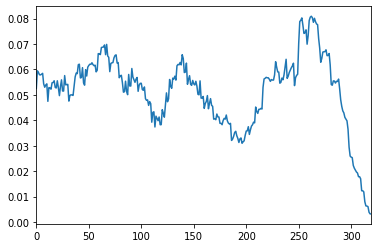

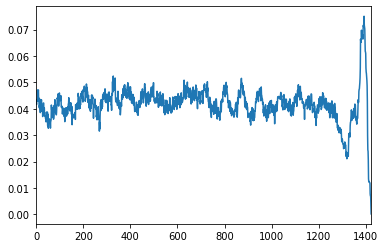

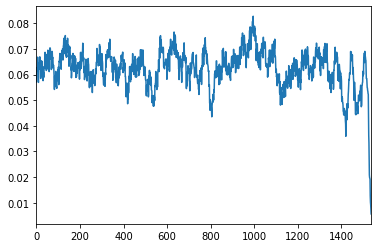

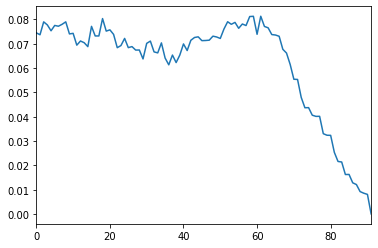

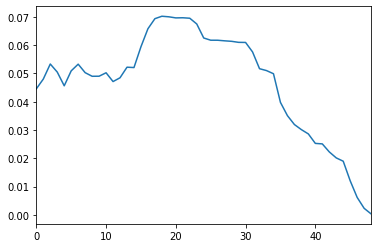

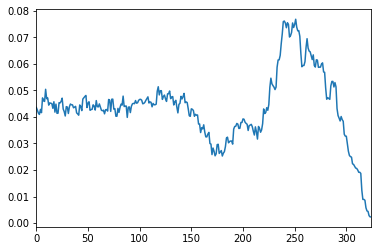

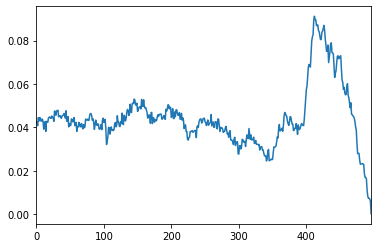

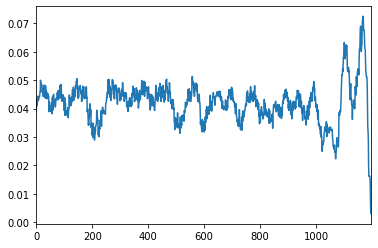

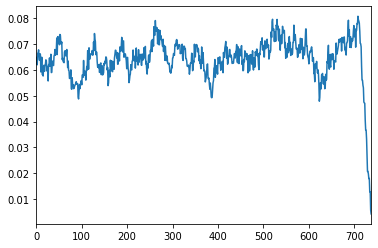

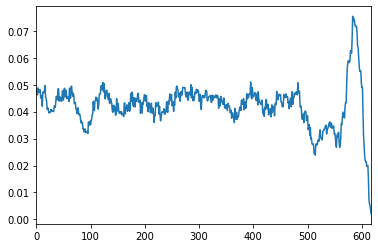

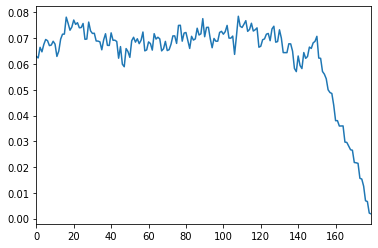

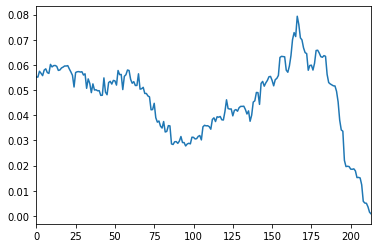

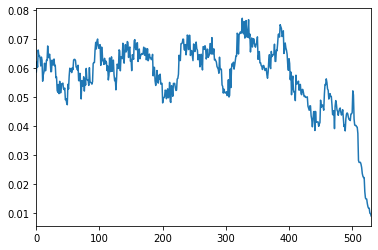

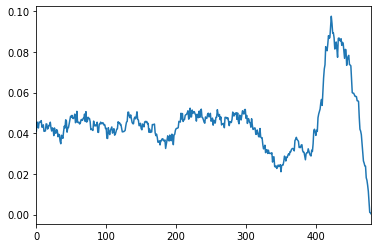

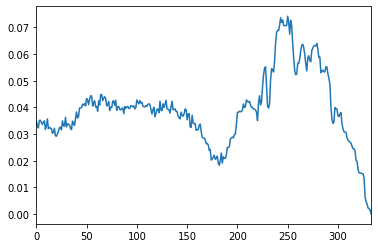

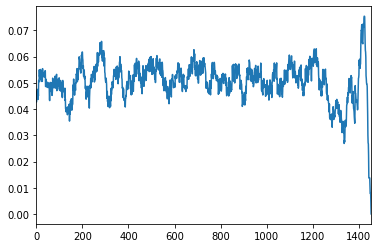

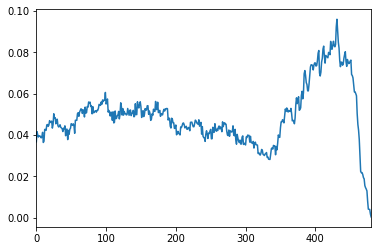

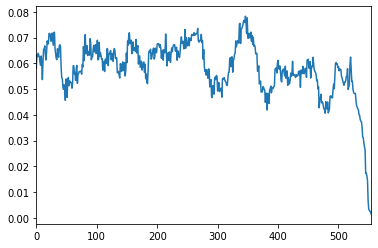

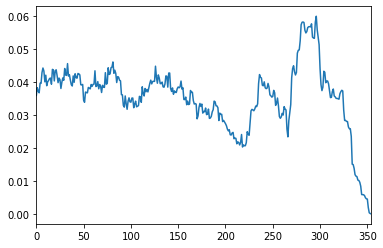

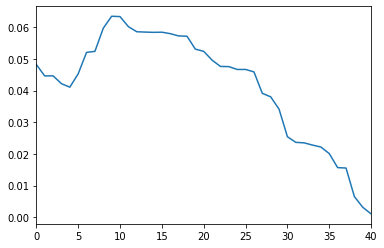

In [13]:
for i in range(0,20):
    plt.figure()
    df[i]['sensor3'].plot()
    plt.show()

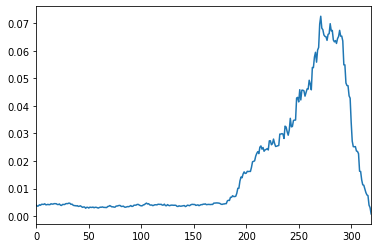

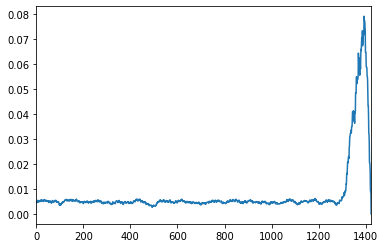

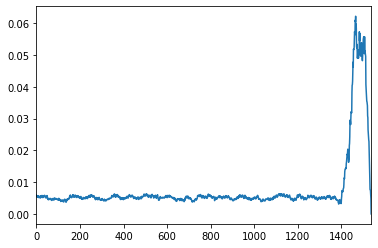

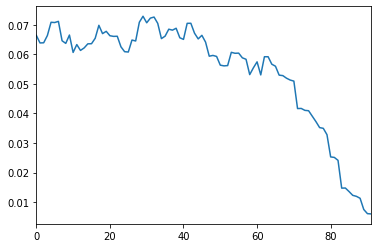

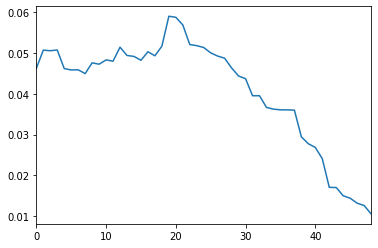

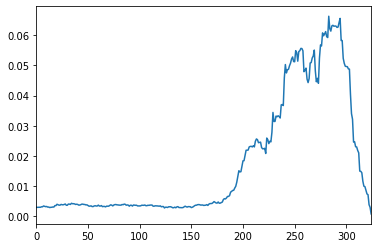

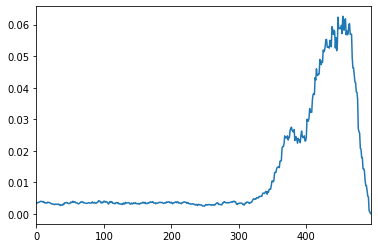

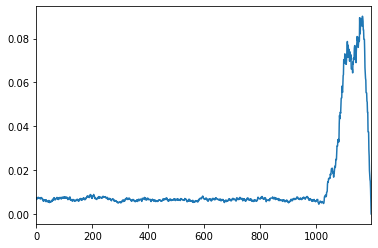

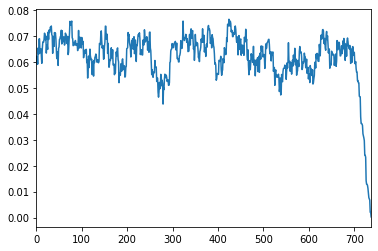

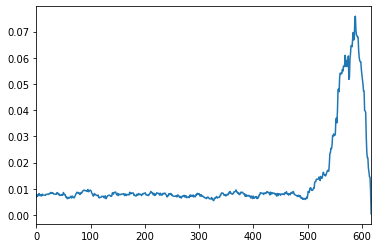

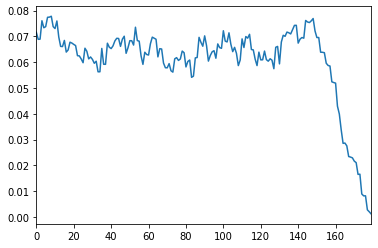

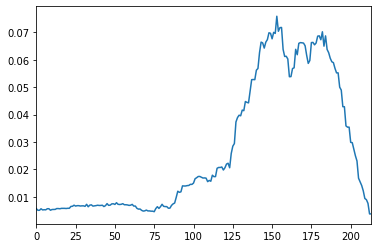

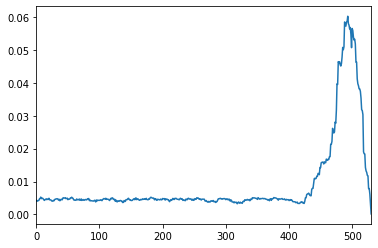

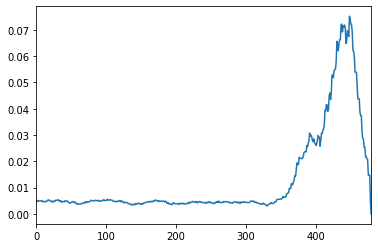

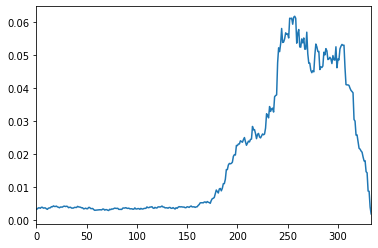

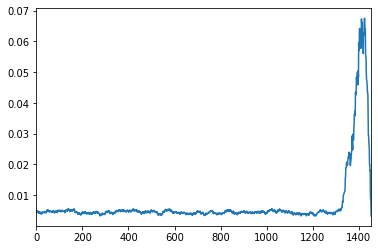

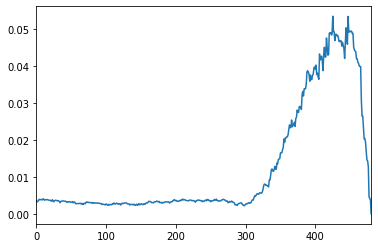

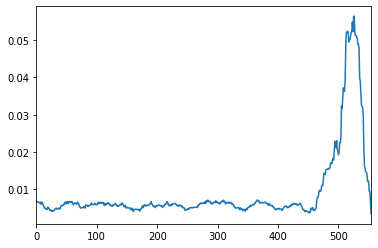

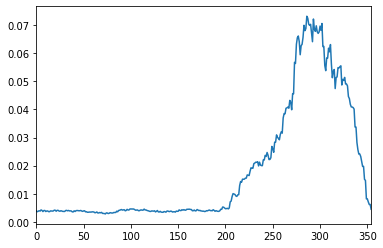

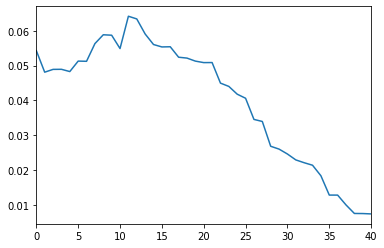

In [14]:
for i in range(0,20):
    plt.figure()
    df[i]['sensor4'].plot()
    plt.show()

# Test data

In [17]:
df_test=df[0]

# Splitting data into train and test data

In [18]:
train_X, train_y = df_train[['sensor1','sensor2','sensor3','sensor4']], df_train['labels']
test_X, test_y = df_test[['sensor1','sensor2','sensor3','sensor4']], df_test['labels']
train_X, train_y = train_X.values,train_y.values
test_X, test_y = test_X.values,test_y.values

# Series to supervised

In [16]:
import pandas as pd
def series_to_supervised(data, n_in, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:
train_X=series_to_supervised(train_X,8,dropnan=True)
train_X=train_X.values
train_y=train_y[8:]
test_X=series_to_supervised(test_X,8,dropnan=True)
test_X=test_X.values
test_y=test_y[8:]

# Reshaping values to send for LSTM

In [20]:
train_X = train_X.reshape((train_X.shape[0], 8, 4))
test_X = test_X.reshape((test_X.shape[0], 8, 4))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(11095, 8, 4) (11095,) (312, 8, 4) (312,)


In [21]:
train_X

array([[[0.0268408, 0.004284 , 0.0421167, 0.0049415],
        [0.0284639, 0.0045131, 0.0416169, 0.0045177],
        [0.0289793, 0.0045161, 0.0434877, 0.0045766],
        ...,
        [0.0284741, 0.0042803, 0.047107 , 0.0047312],
        [0.0275255, 0.0045778, 0.0451127, 0.0049323],
        [0.0273446, 0.0043893, 0.0430974, 0.0054806]],

       [[0.0284639, 0.0045131, 0.0416169, 0.0045177],
        [0.0289793, 0.0045161, 0.0434877, 0.0045766],
        [0.0290741, 0.0043239, 0.0428135, 0.0047954],
        ...,
        [0.0275255, 0.0045778, 0.0451127, 0.0049323],
        [0.0273446, 0.0043893, 0.0430974, 0.0054806],
        [0.0262651, 0.0043175, 0.0468091, 0.0049361]],

       [[0.0289793, 0.0045161, 0.0434877, 0.0045766],
        [0.0290741, 0.0043239, 0.0428135, 0.0047954],
        [0.0297195, 0.0042999, 0.0428031, 0.0050124],
        ...,
        [0.0273446, 0.0043893, 0.0430974, 0.0054806],
        [0.0262651, 0.0043175, 0.0468091, 0.0049361],
        [0.025464 , 0.0047575, 0.047117

# Building RNN model

In [234]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, Activation,LSTM, GRU
from keras import optimizers
def RNN(learning_rate,hiddenUnits):
    model=Sequential()
    model.add(SimpleRNN(units=hiddenUnits,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [235]:
RNN_model=RNN(learning_rate=0.001,hiddenUnits=100)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 100)               10500     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 10,601
Trainable params: 10,601
Non-trainable params: 0
_________________________________________________________________
None


In [236]:
history=RNN_model.fit(train_X,train_y,batch_size=256,epochs=15,validation_data=(test_X,test_y))

Train on 11095 samples, validate on 312 samples
Epoch 1/15
11095/11095 [==============================] - 1s 51us/step - loss: 0.5504 - accuracy: 0.7400 - val_loss: 0.3517 - val_accuracy: 0.8654
Epoch 2/15
11095/11095 [==============================] - 0s 23us/step - loss: 0.5111 - accuracy: 0.7499 - val_loss: 0.3274 - val_accuracy: 0.9263
Epoch 3/15
11095/11095 [==============================] - 0s 21us/step - loss: 0.5046 - accuracy: 0.7566 - val_loss: 0.3443 - val_accuracy: 0.8301
Epoch 4/15
11095/11095 [==============================] - 0s 23us/step - loss: 0.5001 - accuracy: 0.7530 - val_loss: 0.3415 - val_accuracy: 0.8462
Epoch 5/15
11095/11095 [==============================] - ETA: 0s - loss: 0.4983 - accuracy: 0.75 - 0s 23us/step - loss: 0.4960 - accuracy: 0.7531 - val_loss: 0.2675 - val_accuracy: 0.9647
Epoch 6/15
11095/11095 [==============================] - ETA: 0s - loss: 0.4760 - accuracy: 0.77 - 0s 23us/step - loss: 0.4706 - accuracy: 0.7838 - val_loss: 0.3164 - val_acc

In [237]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_accuracy,loss,accuracy
0,0.351735,0.865385,0.550390,0.739973
1,0.327361,0.926282,0.511122,0.749887
2,0.344342,0.830128,0.504567,0.756647
3,0.341478,0.846154,0.500099,0.753042
4,0.267499,0.964744,0.495999,0.753132
5,0.316407,0.939103,0.470593,0.783776
6,0.232381,0.967949,0.455231,0.802794
7,0.267017,0.967949,0.451047,0.803425
8,0.360507,0.955128,0.446487,0.807301
9,0.214724,0.964744,0.441326,0.808653


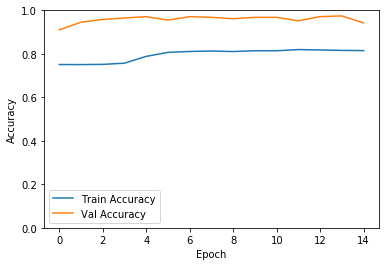

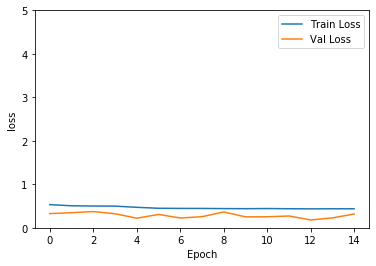

In [225]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

# Building LSTM model

In [249]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, Activation,LSTM, GRU
from keras import optimizers
def LSTMfunction(learning_rate):
    model=Sequential()
    model.add(LSTM(100,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [250]:
LSTM_model=LSTMfunction(learning_rate=0.001)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________
None


In [251]:
history=LSTM_model.fit(train_X,train_y,batch_size=128,epochs=15,validation_data=(test_X,test_y))

Train on 11095 samples, validate on 312 samples
Epoch 1/15
11095/11095 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.74 - 1s 124us/step - loss: 0.5586 - accuracy: 0.7447 - val_loss: 0.3363 - val_accuracy: 0.9071
Epoch 2/15
11095/11095 [==============================] - 1s 90us/step - loss: 0.4893 - accuracy: 0.7857 - val_loss: 0.3376 - val_accuracy: 0.9583
Epoch 3/15
11095/11095 [==============================] - 1s 89us/step - loss: 0.4782 - accuracy: 0.7891 - val_loss: 0.3614 - val_accuracy: 0.9647
Epoch 4/15
11095/11095 [==============================] - 1s 89us/step - loss: 0.4666 - accuracy: 0.7912 - val_loss: 0.3586 - val_accuracy: 0.9712
Epoch 5/15
11095/11095 [==============================] - 1s 98us/step - loss: 0.4673 - accuracy: 0.7921 - val_loss: 0.3143 - val_accuracy: 0.9679
Epoch 6/15
11095/11095 [==============================] - 1s 113us/step - loss: 0.4660 - accuracy: 0.7931 - val_loss: 0.3021 - val_accuracy: 0.9744
Epoch 7/15
11095/11095 [==

In [252]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_accuracy,loss,accuracy
0,0.336295,0.907051,0.558634,0.744660
1,0.337592,0.958333,0.489256,0.785669
2,0.361379,0.964744,0.478201,0.789094
3,0.358598,0.971154,0.466552,0.791167
4,0.314263,0.967949,0.467264,0.792068
5,0.302110,0.974359,0.465958,0.793060
6,0.278048,0.971154,0.458355,0.794412
7,0.365148,0.955128,0.454237,0.797747
8,0.343534,0.958333,0.445129,0.805858
9,0.289659,0.964744,0.443901,0.806850


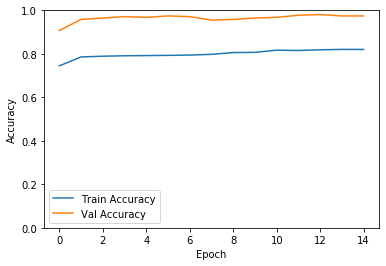

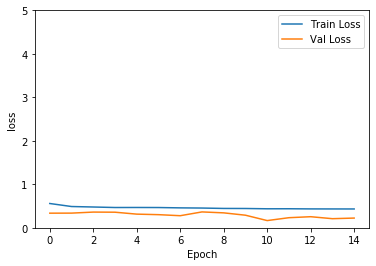

In [253]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

# Building GRU model

In [254]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, Activation,LSTM, GRU
from keras import optimizers
def GRUfunction(learning_rate):
    model=Sequential()
    model.add(GRU(100,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [255]:
GRU_model=GRUfunction(learning_rate=0.001)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               31500     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 31,601
Trainable params: 31,601
Non-trainable params: 0
_________________________________________________________________
None


In [256]:
history=GRU_model.fit(train_X,train_y,batch_size=128,epochs=15,validation_data=(test_X,test_y))

Train on 11095 samples, validate on 312 samples
Epoch 1/15
11095/11095 [==============================] - 2s 172us/step - loss: 0.5737 - accuracy: 0.7459 - val_loss: 0.4555 - val_accuracy: 0.7436
Epoch 2/15
11095/11095 [==============================] - 1s 112us/step - loss: 0.4980 - accuracy: 0.7726 - val_loss: 0.3387 - val_accuracy: 0.9583
Epoch 3/15
11095/11095 [==============================] - 1s 98us/step - loss: 0.4812 - accuracy: 0.7882 - val_loss: 0.3410 - val_accuracy: 0.9647
Epoch 4/15
11095/11095 [==============================] - 1s 110us/step - loss: 0.4710 - accuracy: 0.7902 - val_loss: 0.2975 - val_accuracy: 0.9679
Epoch 5/15
11095/11095 [==============================] - 1s 107us/step - loss: 0.4688 - accuracy: 0.7904 - val_loss: 0.3868 - val_accuracy: 0.9776
Epoch 6/15
11095/11095 [==============================] - 1s 113us/step - loss: 0.4644 - accuracy: 0.7925 - val_loss: 0.3629 - val_accuracy: 0.9712
Epoch 7/15
11095/11095 [==============================] - 1s 100u

In [257]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_accuracy,loss,accuracy
0,0.455497,0.743590,0.573691,0.745922
1,0.338736,0.958333,0.498025,0.772600
2,0.340955,0.964744,0.481230,0.788193
3,0.297455,0.967949,0.470997,0.790176
4,0.386814,0.977564,0.468819,0.790446
5,0.362852,0.971154,0.464361,0.792519
6,0.305939,0.967949,0.466858,0.791888
7,0.300956,0.967949,0.465559,0.793511
8,0.307360,0.971154,0.461878,0.793781
9,0.302235,0.964744,0.456143,0.796395


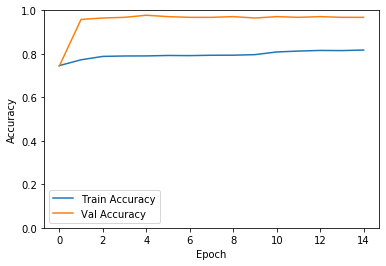

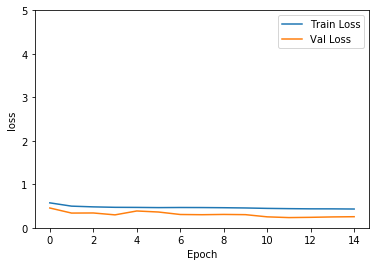

In [258]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)